# Importation des packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Importation des données

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1mx-CAzT10YKrmxHfYDP_1Oef7PVGUr7s?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Etude du jeu de données

Dataset Shape: (159571, 8)
Columns: Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')
Sample Data:
                  id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0 

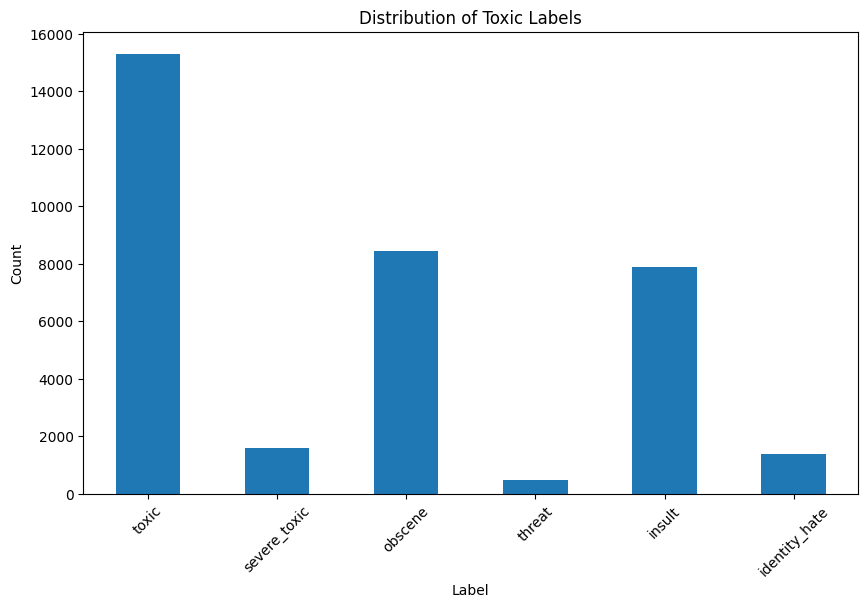

Comment Length Stats:
 count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_length, dtype: float64


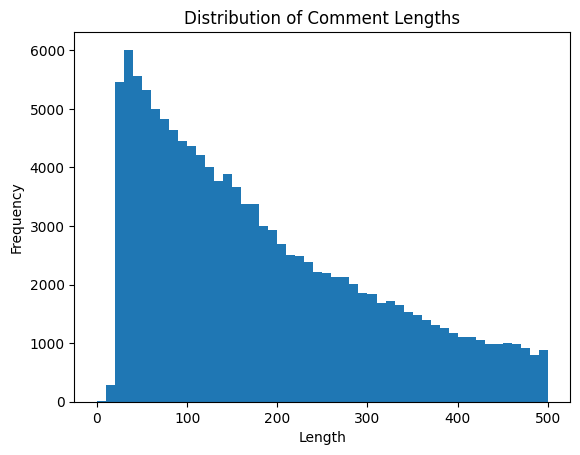

In [ ]:
# Your Code
# Etude du jeu de données
print("Dataset Shape:", data.shape)
print("Columns:", data.columns)
print("Sample Data:\n", data.head())

# Check for missing values
print("Missing Values:\n", data.isnull().sum())

# Label distribution (assuming multi-label columns start from index 2)
labels = data.columns[2:]
label_counts = data[labels].sum()
print("Label Distribution:\n", label_counts)

# Visualize label distribution
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title("Distribution of Toxic Labels")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

# Comment length analysis
data['comment_length'] = data['comment_text'].apply(len)
print("Comment Length Stats:\n", data['comment_length'].describe())
plt.hist(data['comment_length'], bins=50, range=(0, 500))
plt.title("Distribution of Comment Lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

# Préparation des données

In [ ]:
# Your Code
# Préparation des données
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

# Use a subset for faster iteration (e.g., 10% of data)
data_subset = data.sample(frac=0.1, random_state=42)

# Basic text cleaning function
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
    return text

data_subset['comment_text'] = data_subset['comment_text'].apply(clean_text)

# Tokenization
MAX_WORDS = 5000  # Vocabulary size
MAX_LEN = 100     # Max sequence length
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(data_subset['comment_text'])
sequences = tokenizer.texts_to_sequences(data_subset['comment_text'])
X = pad_sequences(sequences, maxlen=MAX_LEN)

# Prepare labels (assuming multi-label)
y = data_subset[labels].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)

X_train Shape: (12765, 100)
y_train Shape: (12765, 6)


# Entraînement du modèle baseline

In [ ]:
# Your Code
# Entraînement du modèle baseline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score

tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(data_subset['comment_text'])
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Modèle de régression logistique multi-étiquettes
baseline_model = OneVsRestClassifier(LogisticRegression(max_iter=1000))
baseline_model.fit(X_train_tfidf, y_train)

# Évaluation
y_pred = baseline_model.predict(X_test_tfidf)
print("Baseline F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))

Baseline F1 Score (macro): 0.3021050972256299


# Itération de la modélisation

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 100, 128)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │             198 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 743,142 (2.83 MB)

 Trainable params: 743,142 (2.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.4123 - loss: 0.3988 - val_accuracy: 0.9959 - val_loss: 0.0845
Epoch 2/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.7959 - loss: 0.1459 - val_accuracy: 0.9950 - val_loss: 0.0701
Epoch 3/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.8979 - loss: 0.1165 - val_accuracy: 0.9959 - val_loss: 0.0692
Epoch 4/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9300 - loss: 0.1108 - val_accuracy: 0.9956 - val_loss: 0.0761
Epoch 5/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.9152 - loss: 0.1103 - val_accuracy: 0.9959 - val_loss: 0.0722
Epoch 6/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9644 - loss: 0.0926 - val_accuracy: 0.9959 - val_loss: 0.0757
Epoch 7/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.9585 - loss: 0.0876 - val_accuracy: 0.9959 - val_loss: 0.0830
Epoch 8/10
399/399 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.9782 - loss: 0.0865 - val_

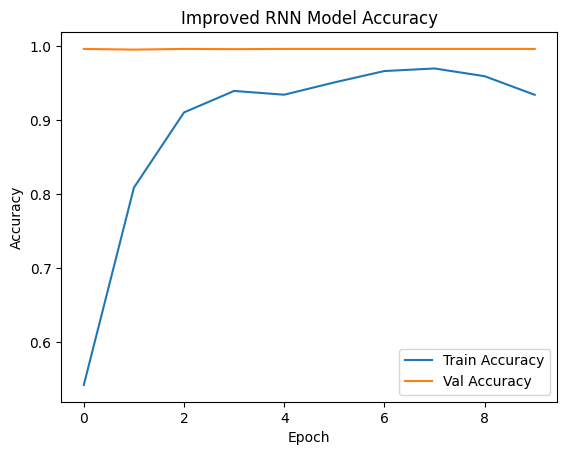

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Improved RNN F1 Score (macro): 0.38958434161748273


In [ ]:
# Your Code
# Itération de la modélisation améliorée
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Définir les constantes
MAX_WORDS = 5000
MAX_LEN = 100
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Modèle amélioré
model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=128),  # Sans input_length
    Bidirectional(LSTM(64, return_sequences=False)),  # Bidirectional pour mieux capturer le contexte
    Dropout(0.5),
    Dense(32, activation='relu'),  # Couche intermédiaire pour plus de complexité
    Dropout(0.3),
    Dense(len(labels), activation='sigmoid')  # Sortie multi-étiquettes
])

# Compilation avec poids de classe pour gérer le déséquilibre (optionnel)
class_weights = {i: (1.0 / count) * (len(y_train) / len(labels)) for i, count in enumerate(y_train.sum(axis=0))}
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Construction explicite
model.build(input_shape=(None, MAX_LEN))
model.summary()

# Entraînement avec plus d'époques
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weights)

# Visualisation
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Improved RNN Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Évaluation avec seuil ajusté par classe (exemple simplifié)
y_pred_rnn = model.predict(X_test)
thresholds = [0.3] * len(labels)  # Ajuster selon les classes, ici simplifié
y_pred_rnn_adjusted = (y_pred_rnn > thresholds).astype(int)
print("Improved RNN F1 Score (macro):", f1_score(y_test, y_pred_rnn_adjusted, average='macro'))

## Pipeline

In [ ]:
# Pipeline
def classify_comment(comment):
    cleaned_comment = clean_text(comment)
    seq = tokenizer.texts_to_sequences([cleaned_comment])
    padded = pad_sequences(seq, maxlen=MAX_LEN)
    prediction = model.predict(padded)[0]
    result = {label: float(pred) for label, pred in zip(labels, prediction)}
    return result

# Test
test_comment = "I will kill you!"
result = classify_comment(test_comment)
print("Prediction for test comment:")
for label, score in result.items():
    print(f"{label}: {score:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction for test comment:
toxic: 0.7338
severe_toxic: 0.0583
obscene: 0.4218
threat: 0.0852
insult: 0.4397
identity_hate: 0.2059
